In [1]:
from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

import pandas as pd
import numpy as np

from IPython.display import display, Markdown

import locale
_ = locale.setlocale(locale.LC_ALL, "it_IT")

In [ ]:
def smooth(y):
    y_smoothed = y.rolling(7,
            win_type='gaussian',
            min_periods=1,
            center=True).mean(std=2).round()
    return y_smoothed

ita = None
url_ita = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv'
ita = pd.read_csv(url_ita,
                     usecols=['data', 'totale_positivi', 'dimessi_guariti', 'deceduti'],
                     parse_dates=['data'],
                     index_col=['data'],
                     squeeze=True).sort_index()

dI = ita["totale_positivi"].diff()[1:]
dR = ita["dimessi_guariti"].diff()[1:]
dD = ita["deceduti"].diff()[1:]

dI_s = smooth(dI)
dR_s = smooth(dR)
dD_s = smooth(dD)

_R0 = (dI_s / (dR_s + dD_s)) + 1
R0 = pd.DataFrame(
    data={"R0": _R0.values},
    index=dI.index
)

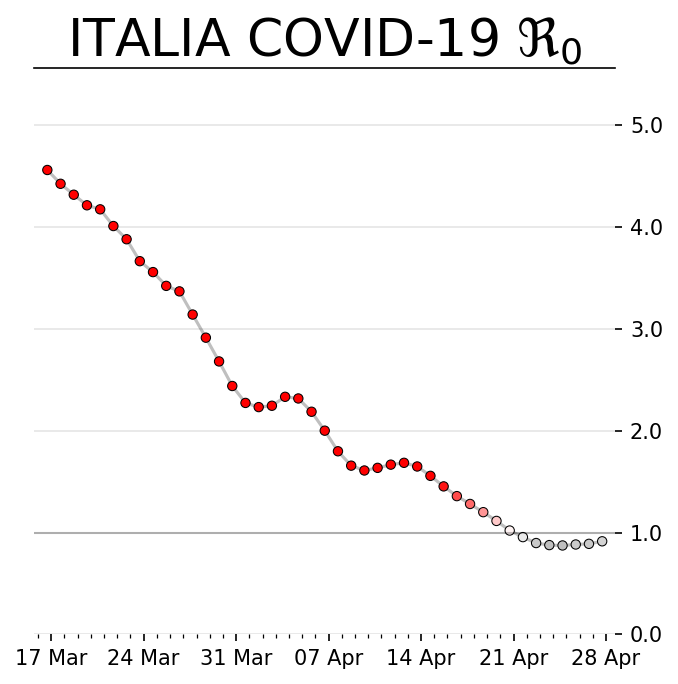

In [13]:
def plot_r0(result, state_name, offset=10):
    
    fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=150)
    
    ax.set_title(f"{state_name} $\Re_0$", fontsize=25)
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result.index.get_level_values('data')[offset:]
    values = result["R0"].values[offset:]
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=20,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    extended = [
        pd.Timestamp(index[0]) - pd.Timedelta(days=1),
        index[-1] + pd.Timedelta(days=1)
    ]

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.WeekdayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
    
    #ax.xaxis.set_major_locator(mdates.MonthLocator())
    #ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    #ax.tick_params(axis="x", which='major', labelsize=12, pad=15)
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    #ax.xaxis.set_minor_formatter(mdates.DateFormatter('%d'))
    #ax.tick_params(axis="x", which='minor', labelsize=9)
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, max(values) + 1)
    ax.set_xlim(extended)
    fig.set_facecolor('w')
    plt.show()
    
plot_r0(R0, "ITALIA COVID-19", offset=20)